# Introduction
In this example, we will build a multi-label text classifier to predict the subject areas of arXiv papers from their abstract bodies. This type of classifier can be useful for conference submission portals like OpenReview. Given a paper abstract, the portal could provide suggestions for which areas the paper would best belong to.

The dataset was collected using the arXiv Python library that provides a wrapper around the original arXiv API. Additionally, you can also find the dataset on Kaggle.

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### EDA

In [2]:
arxiv_data = pd.read_csv(
    "https://github.com/soumik12345/multi-label-text-classification/releases/download/v0.2/arxiv_data.csv"
)

print(f"There are {len(arxiv_data)} rows in the dataset.")

arxiv_data.head()

There are 51774 rows in the dataset.


,titles,summaries,terms
0,Survey on Semantic Stereo Matching / Semantic ...,Stereo matching is one of the widely used tech...,"['cs.CV', 'cs.LG']"
1,FUTURE-AI: Guiding Principles and Consensus Re...,The recent advancements in artificial intellig...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,Enforcing Mutual Consistency of Hard Regions f...,"In this paper, we proposed a novel mutual cons...","['cs.CV', 'cs.AI']"
3,Parameter Decoupling Strategy for Semi-supervi...,Consistency training has proven to be an advan...,['cs.CV']
4,Background-Foreground Segmentation for Interio...,"To ensure safety in automated driving, the cor...","['cs.CV', 'cs.LG']"


#### Remove Duplicated records

1. Remove row-level duplicates
2. Remove records with same title

In [3]:
print('Total duplicated entries : ', arxiv_data.shape[0] - arxiv_data.drop_duplicates().shape[0])

Total duplicated entries :  12783


In [4]:
arxiv_data = arxiv_data.drop_duplicates()
print('Data volume after removing duplicates : ', arxiv_data.shape[0])

Data volume after removing duplicates :  38991


In [5]:
arxiv_data = arxiv_data[~arxiv_data["titles"].duplicated()]
print(f"There are {len(arxiv_data)} rows in the final deduplicated dataset.")

There are 38972 rows in the final deduplicated dataset.


#### Analyse terms

In [6]:
arxiv_data['terms'].unique()

array(["['cs.CV', 'cs.LG']", "['cs.CV', 'cs.AI', 'cs.LG']",
       "['cs.CV', 'cs.AI']", ..., "['stat.ML', 'cs.LG', 'I.2.1; J.3']",
       "['cs.LG', 'cs.NE', 'q-bio.BM', 'stat.ML']",
       "['stat.ML', 'cs.CV', 'cs.LG', 'q-bio.QM']"], dtype=object)

In [7]:
arxiv_data['terms'].value_counts()

['cs.CV']                                          12747
['cs.LG', 'stat.ML']                                4074
['cs.LG']                                           2046
['cs.CV', 'cs.LG']                                  1486
['cs.LG', 'cs.AI']                                  1206
                                                   ...  
['cs.LG', 'cs.CL', 'cs.HC', 'stat.ML']                 1
['cs.LG', 'cs.AI', 'cs.CL', 'cs.PL', 'stat.ML']        1
['cs.LG', 'cs.CL', 'stat.ME', 'stat.ML']               1
['cs.LG', 'cs.CL', 'cs.LO', 'stat.ML']                 1
['stat.ML', 'cs.CV', 'cs.LG', 'q-bio.QM']              1
Name: terms, Length: 3157, dtype: int64

Out of 3157 distinct labels, 2321 labels occur only once. In order to better prepare the data for classification and the problem itself, we should remove these entries

In [8]:
arxiv_data.groupby("terms").filter(lambda x: len(x) == 1).shape[0]

2321

In [9]:
# Filtering the rare terms
arxiv_data_filtered = arxiv_data.groupby("terms").filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(36651, 3)

### Convert the string labels to lists of strings
The initial labels are represented as raw strings. Here we make them List[str] for a more compact representation.

In [10]:
arxiv_data_filtered["terms"] = arxiv_data_filtered["terms"].apply(
    lambda x: literal_eval(x)
)
arxiv_data_filtered["terms"].values[:5]

array([list(['cs.CV', 'cs.LG']), list(['cs.CV', 'cs.AI', 'cs.LG']),
       list(['cs.CV', 'cs.AI']), list(['cs.CV']),
       list(['cs.CV', 'cs.LG'])], dtype=object)

### Use stratified splits because of class imbalance
The dataset has a class imbalance problem. So, to have a fair evaluation result, we need to ensure the datasets are sampled with stratification.

In [11]:
test_split = 0.1

# Initial train and test split
train_df, test_df = train_test_split(
    arxiv_data_filtered,
    test_size=test_split,
    stratify=arxiv_data_filtered["terms"].values,
)

# Splitting the test set further into validation
# and new test sets
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 32985
Number of rows in validation set: 1833
Number of rows in test set: 1833


### Multi-label binarization
Now we preprocess our labels using the StringLookup layer

In [12]:
terms = tf.ragged.constant(train_df["terms"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.CR', 'math.OC', 'eess.SP', 'cs.GR', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'cs.MA', 'eess.SY', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'cs.CY', 'stat.AP', 'stat.TH', 'math.ST', 'stat.ME', 'eess.AS', 'cs.SD', 'q-bio.QM', 'q-bio.NC', 'cs.DS', 'cs.GT', 'cs.SE', 'cs.CG', 'cs.NI', 'stat.CO', 'I.2.6', 'math.NA', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'q-bio.BM', 'cs.LO', 'cond-mat.dis-nn', '68T45', 'math.PR', 'cs.PL', 'physics.comp-ph', 'cs.CE', 'cs.AR', 'I.2.10', 'q-fin.ST', 'cond-mat.stat-mech', 'quant-ph', 'math.DS', '68T05', 'cs.CC', 'I.4.6', 'physics.data-an', 'physics.soc-ph', 'physics.ao-ph', 'cs.DM', 'econ.EM', 'q-bio.GN', 'physics.med-ph', 'cs.PF', 'astro-ph.IM', 'I.4.8', 'math.AT', 'cs.FL', 'I.4', 'q-fin.TR', 'I.5.4', 'I.2', '68U10', 'hep-ex', '68T10', 'physics.geo-ph', 'cond-mat.mtrl-sci', 'q-fin.CP', 'physics.optics', 'physics.flu-dyn', 'math.CO', 'math.AP', 'I.4; I.5', 'I.4.9', 'I.2.6

Here we are separating the individual unique classes available from the label pool and then using this information to represent a given label set with 0's and 1's. Below is an example.

In [13]:
sample_label = train_df["terms"].iloc[10]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.CV']
Label-binarized representation: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Data preprocessing and tf.data.Dataset objects
We first get percentile estimates of the sequence lengths.

In [14]:
train_df["summaries"].apply(lambda x: len(x.split(" "))).describe()

count    32985.000000
mean       156.403183
std         41.513529
min          5.000000
25%        128.000000
50%        154.000000
75%        183.000000
max        462.000000
Name: summaries, dtype: float64

Notice that 50% of the abstracts have a length of 156. So, any number close to that value is a good enough approximate for the maximum sequence length.

Now, we implement utilities to prepare our datasets.

In [15]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["terms"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["summaries"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

Now we can prepare the tf.data.Dataset objects.

In [16]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

### Dataset preview

In [17]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Popular sparse estimation methods based on $\\ell_1$-relaxation, such as the\nLasso and the Dantzig selector, require the knowledge of the variance of the\nnoise in order to properly tune the regularization parameter. This constitutes\na major obstacle in applying these methods in several frameworks---such as time\nseries, random fields, inverse problems---for which the noise is rarely\nhomoscedastic and its level is hard to know in advance. In this paper, we\npropose a new approach to the joint estimation of the conditional mean and the\nconditional variance in a high-dimensional (auto-) regression setting. An\nattractive feature of the proposed estimator is that it is efficiently\ncomputable even for very large scale problems by solving a second-order cone\nprogram (SOCP). We present theoretical analysis and numerical results assessing\nthe performance of the proposed procedure.'
Label(s): ['stat.ML']
 
Abstract: b'We propose a self-supervised framework to learn scene rep

### Vectorization
Before we feed the data to our model, we need to vectorize it (represent it in a numerical form). For that purpose, we will use the TextVectorization layer. It can operate as a part of your main model so that the model is excluded from the core preprocessing logic. This greatly reduces the chances of training / serving skew during inference.

We first calculate the number of unique words present in the abstracts.

In [18]:
# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["summaries"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

153313


We now create our vectorization layer and map() to the tf.data.Datasets created earlier

In [19]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

`TextVectorization` layer needs to be adapted as per the vocabulary from our training set

In [20]:
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

A batch of raw text will first go through the TextVectorization layer and it will generate their integer representations. Internally, the TextVectorization layer will first create bi-grams out of the sequences and then represent them using TF-IDF. The output representations will then be passed to the shallow model responsible for text classification.

### Create a text classification model
We will keep our model simple -- it will be a small stack of fully-connected layers with ReLU as the non-linearity.

In [21]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

### Train the model
We will train our model using the binary crossentropy loss. This is because the labels are not disjoint. For a given abstract, we may have multiple categories. So, we will divide the prediction task into a series of multiple binary classification problems. This is also why we kept the activation function of the classification layer in our model to sigmoid. Researchers have used other combinations of loss function and activation function as well. For example, in Exploring the Limits of Weakly Supervised Pretraining, Mahajan et al. used the softmax activation function and cross-entropy loss to train their models.

In [22]:
epochs = 20

# Initialize model
shallow_mlp_model = make_model()

# Compile the model
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

# Fit the model
history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/20
258/258 [==============================] - 16s 50ms/step - loss: 0.0314 - categorical_accuracy: 0.8600 - val_loss: 0.0188 - val_categorical_accuracy: 0.8876
Epoch 2/20
258/258 [==============================] - 13s 50ms/step - loss: 0.0029 - categorical_accuracy: 0.8745 - val_loss: 0.0276 - val_categorical_accuracy: 0.8860
Epoch 3/20
258/258 [==============================] - 13s 50ms/step - loss: 8.2100e-04 - categorical_accuracy: 0.8532 - val_loss: 0.0320 - val_categorical_accuracy: 0.8838
Epoch 4/20
258/258 [==============================] - 13s 50ms/step - loss: 3.8988e-04 - categorical_accuracy: 0.8390 - val_loss: 0.0374 - val_categorical_accuracy: 0.8669
Epoch 5/20
258/258 [==============================] - 13s 52ms/step - loss: 2.3898e-04 - categorical_accuracy: 0.8237 - val_loss: 0.0399 - val_categorical_accuracy: 0.8505
Epoch 6/20
258/258 [==============================] - 13s 50ms/step - loss: 1.4013e-04 - categorical_accuracy: 0.8199 - val_loss: 0.0426 - val_categ

Training and Validation Plots

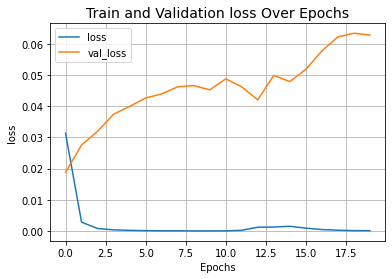

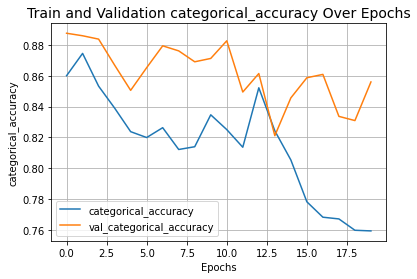

In [23]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

### Observations

1. No learning is happening after first 2-3 epochs. Loss is constant. Ideally it would decrease over epochs
2. Validation loss is increasing, which indicates a overfit model
3. Categorical Accuracy is decreasing over time, only a slight increase in the initial epochs, which confirms 1st observation
4. Same with validation data

Overall, we can conclude the model performance is not up to the mark, and some changes to data preparation, data cleaning, model architecture are required

### Evaluate the model

In [24]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

15/15 [==============================] - 1s 58ms/step - loss: 0.0607 - categorical_accuracy: 0.8331
Categorical accuracy on the test set: 83.31%.
